**GTZAN - MFCC**

**Team Members**:

*   Francis, Rikky Linuz - UTA ID: 1001753137
*   Mukka, Himaneesh - UTA ID: 1001861524
*   Smitherman, Samuel M - UTA ID: 1000762170

Link of the google colab: https://colab.research.google.com/drive/1ZTBOMZ3tbkkzJT8TDNyIYRhiPHzRxPs7?usp=sharing

In [ ]:
import json
import os
import math
import librosa
import librosa.display
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
import tensorflow.keras as keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow as tf
import warnings

from google.colab import drive



import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Bidirectional, LSTM, Dropout, Activation, GRU
from keras.layers import Conv2D, concatenate, MaxPooling2D, Flatten, Embedding, Lambda


from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend as K
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop

from keras import regularizers


import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
## GTZAN dataset details
DATASET_PATH = "/content/drive/MyDrive/GTZAN/genres"
JSON_PATH = "/content/drive/MyDrive/1segment/data-gtzan.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [ ]:
## Method to save GTZAN MFCC into data.json
## hop_length=512 num_segments=1
def save_mfcc(dataset_path, json_path, num_mfcc=20, n_fft=2048, hop_length=512, num_segments=1):

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        
        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

		            # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i-1)
                        print("{}, segment:{}".format(file_path, d+1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH)


Processing: jazz
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00007.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00005.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00003.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00004.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00006.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00002.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00000.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00001.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00008.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00017.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00018.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00012.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00014.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jazz.00013.wav, segment:1
/content/drive/MyDrive/GTZAN/genres/jazz/jaz

In [ ]:
GTZAN_DATA_PATH = "/content/drive/MyDrive/1segment/data-gtzan.json"

In [ ]:
## Load the MFCC data from data.json in the given path
def load_data(data_path):
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


In [ ]:
# load data
X, y = load_data(GTZAN_DATA_PATH)

In [ ]:
print(X.shape)
print(y.shape)

(999, 1292, 20)
(999,)


In [ ]:
# get train, validation, test splits
# create train, validation and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, random_state=42, stratify=y_train, test_size=0.25)

In [ ]:
print(X_train.shape)
print(X_validation.shape)
print(X_test.shape)

(561, 1292, 20)
(188, 1292, 20)
(250, 1292, 20)


In [ ]:
batch_size = 32
num_classes = 10
n_features = X_train.shape[2]
n_time = X_train.shape[1]

In [ ]:
nb_filters1=16 
nb_filters2=32 
nb_filters3=64
nb_filters4=64
nb_filters5=64
ksize = (3,1)
pool_size_1= (2,2) 
pool_size_2= (4,4)
pool_size_3 = (4,2)

dropout_prob = 0.20
dense_size1 = 128
lstm_count = 64
num_units = 120

BATCH_SIZE = 64
# make it to 128, filter 64
EPOCH_COUNT = 50
L2_regularization = 0.001

In [ ]:
## Create the model of the layers as per the input shape
def conv_recurrent_model_build(input_shape):
    layer = input_shape
    
    ### Convolutional blocks
    conv_1 = Conv2D(filters = nb_filters1, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_1')(layer)
    pool_1 = MaxPooling2D(pool_size_1)(conv_1)

    conv_2 = Conv2D(filters = nb_filters2, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_2')(conv_1)
    pool_2 = MaxPooling2D(pool_size_1)(conv_2)

    conv_3 = Conv2D(filters = nb_filters3, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_3')(conv_2)
    pool_3 = MaxPooling2D(pool_size_1)(conv_3)
    
    
    conv_4 = Conv2D(filters = nb_filters4, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_4')(conv_3)
    pool_4 = MaxPooling2D(pool_size_2)(conv_4)
    
    
    conv_5 = Conv2D(filters = nb_filters5, kernel_size = ksize, strides=1,
                      padding= 'valid', activation='relu', name='conv_5')(conv_4)
    pool_5 = MaxPooling2D(pool_size_2)(conv_5)

    flatten1 = Flatten()(pool_5)
    ### Recurrent Block
    
    # Pooling layer
    pool_lstm1 = MaxPooling2D(pool_size_3, name = 'pool_lstm')(layer)
    
    # Embedding layer

    squeezed = Lambda(lambda x: K.squeeze(x, axis= -1))(pool_lstm1)
    
    # Bidirectional GRU
    lstm = Bidirectional(GRU(lstm_count))(squeezed)  #default merge mode is concat
    
    # Concat Output
    concat = concatenate([flatten1, lstm], axis=-1, name ='concat')
    
    ## Softmax Output
    output = Dense(num_classes, activation = 'softmax', name='preds')(concat)
    
    model_output = output
    model = Model(input_shape, model_output)
    
#     opt = Adam(lr=0.001)
    opt = RMSprop(lr=0.00001)  # Optimizer
    model.compile(
            loss='sparse_categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )
    
    print(model.summary())

    return model

In [ ]:
def train_model(x_train, y_train, x_val, y_val):
    
    n_frequency = 20
    n_frames = 1292
    #reshape and expand dims for conv2d
#     x_train = x_train.reshape(-1, n_frequency, n_frames)
    x_train = np.expand_dims(x_train, axis = -1)
    
#     x_val = x_val.reshape(-1, n_frequency, n_frames)
    x_val = np.expand_dims(x_val, axis = -1)
    
    
    input_shape = (n_frames, n_frequency, 1)
    model_input = Input(input_shape, name='input')
    
    model = conv_recurrent_model_build(model_input)
    
#     tb_callback = TensorBoard(log_dir='./logs/4', histogram_freq=1, batch_size=32, write_graph=True, write_grads=False,
#                               write_images=False, embeddings_freq=0, embeddings_layer_names=None,
#                               embeddings_metadata=None)
    checkpoint_callback = ModelCheckpoint('./models/parallel/weights.best.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
    reducelr_callback = ReduceLROnPlateau(
                monitor='val_acc', factor=0.5, patience=10, min_delta=0.01,
                verbose=1
            )
    callbacks_list = [checkpoint_callback, reducelr_callback]

    # Fit the model and get training history.
    print('Training...')
    history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCH_COUNT,
                        validation_data=(x_val, y_val), verbose=1, callbacks=callbacks_list)

    return model, history

In [ ]:
model, history  = train_model(X_train, y_train, X_validation, y_validation)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1292, 20, 1) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 1290, 20, 16) 64          input[0][0]                      
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 1288, 20, 32) 1568        conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 1286, 20, 64) 6208        conv_2[0][0]                     
______________________________________________________________________________________________

In [ ]:
def show_summary_stats(history):
    # List all data in history
    print(history.history.keys())

    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


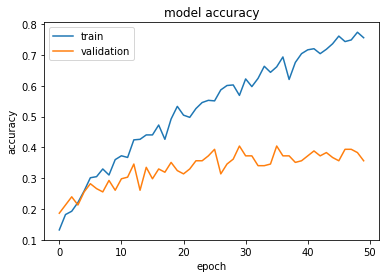

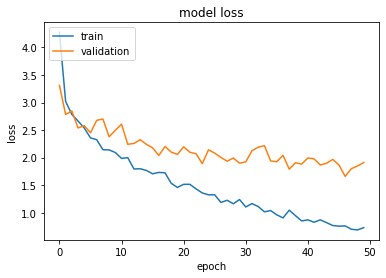

In [ ]:
show_summary_stats(history)

In [ ]:
# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

8/8 - 2s - loss: 1.9291 - accuracy: 0.4080

Test accuracy: 0.40799999237060547


In [ ]:
music_dir ="/content/drive/MyDrive/GTZAN/genres/"
from os import listdir
from os.path import isfile, isdir, join

In [ ]:
mainDirectory = [directory for directory in listdir(music_dir) if isdir(join(music_dir, directory))]

mainDirectory.sort()

print(mainDirectory)

filePaths = []
trackGenres = []

for directory in mainDirectory:
  musicFiles = [fileName for fileName in listdir(join(music_dir, directory))]

  for mf in musicFiles:
    filePaths.append(music_dir + directory + "/" + mf)
    trackGenres.append(directory)

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


In [ ]:
genres = mainDirectory

genreID = {}
genreMap = {}

trackGenreIDs = []

i = 0
for genre in genres:
  genreID[genre] = [i]
  genreMap[i] = genre
  i += 1


In [ ]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = genreID.keys()

In [ ]:
print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

(250,) (250,)
              precision    recall  f1-score   support

       blues       0.36      0.16      0.22        25
   classical       0.43      0.48      0.45        25
     country       0.79      0.76      0.78        25
       disco       0.40      0.16      0.23        25
      hiphop       0.42      0.44      0.43        25
        jazz       0.20      0.40      0.26        25
       metal       0.00      0.00      0.00        25
         pop       0.29      0.32      0.30        25
      reggae       0.42      0.84      0.56        25
        rock       0.62      0.52      0.57        25

    accuracy                           0.41       250
   macro avg       0.39      0.41      0.38       250
weighted avg       0.39      0.41      0.38       250

